# Programming Assignment 2: Clustering


**Assignment submission:** This assignment is to be uploaded as both a .ipynb file and a converted .pdf file **via Gradescope**. For help converting the notebook to a .pdf file, see [this document](https://bit.ly/cos324-colab-pdf). You can submit as often as you need, but only the last submission is graded, and submissions made after the deadline may incur a late penalty depending on your remaining free late hours.

## Assignment Instructions

**Programming assignments will be written in Python.** For more help with using Python, please refer to the pre-work resources in our syllabus and to the notebook from Precept 1.

* **We strongly suggest that you use Google Colab, which has many libraries pre-installed for you. *We will only be supporting Google Colab in office hours*.** We will not be able to help you with issues/instructions regarding local Python environments.
* The instructions for the assignments will provide some guidance on finding useful functions for completing the assignment, but **it will be up to you to search for the exact documentation for specific functions**. Learning to search for helpful information is an important skill for programming.
* **We expect your code to be readable and interpretable**, with meaningful variable names and comments that help us understand your code. Please refer to [PEP 8](https://www.python.org/dev/peps/pep-0008/) for guidance.
* **Consulting TAs (grad or ugrad) and other students from this course is allowed**. Please refer to our collaboration policy for guidance on what is acceptable though, as well as the caution about plagiarism and the need to cite all sources you used.
* **Consulting course staff (e.g. TAs, UCAs) and/or other students from this course is allowed.** Please refer to our collaboration policy for guidance on what is and isn't acceptable.
  * **List your collaborators for each problem in a collaboration statement in the next cell.**
  * You should also **cite all sources** you consulted per problem if they aren't a required or optional course reading. You can do this using a Python comment: `# Consulted this source: ...`.
* **You may not use unauthorized packages or libraries.** If you use code from outside sources or past/other academic work, it must be targeted toward a single and minute purpose (e.g. one or two lines of code for changing the scale of plot axes) and not make up a significant portion of your submission. If you are copying a block of code, you are likely in violation of this rule.

## Collaboration statement
List all collaborators by name, including other students and/or course staff (e.g. TAs, UCAs). If you collaborated with no one on this assignment, write the following: ``"I did not collaborate with anyone on this assignment."``

**I did not collaborate with anyone on this assignment.**


---

## Background/Intuition

As we progress into the age of digital information, the amount of data available for us to work with is staggering. You can peruse a billion images through google search, or query millions of songs with Spotify's API. However, while this data is in abundance, **labels** for it are usually a lot harder to come by. Suppose you wanted to group songs into subjective categories of 'chill and relaxing' versus 'upbeat and energetic'.

You might process these songs and generate some potentially relevant quantifiers, say the average pitch of the song (lower = more bass, higher = more treble) and its average amplitude (lower = quieter, higher = louder).

| Song | Average Pitch | Average Amplitude |
| --- | --- | --- |
| Typhoons, Royal Blood  | -18.1 | 19.6 |
| Waltz No. 2, Shostakovich | -7.6 | 11.2 |
| Sandstorm, Darude | 16.2 | 18.6 |
| ... | ... | ... |
<font size="1">Note: Not real data</font>

But unless you're willing to pay some music-appreciators a lot of money to listen to and review every song (of potentially millions of songs), there's no easy way to get definitive labels of 'relaxing' versus 'upbeat' for this data. Instead we turn towards **unsupervised** learning.
    
If we can cluster these songs into groups of similar pitch and amplitudes, even without labels we might be able to learn a lot about their distribution. We could listen to five or six songs from a cluster of thousands to get a good understanding of what kind of music it represents. And if we have a labeled song, maybe your favorite upbeat track for when you're at the gym, we can look at what cluster it gets put into and explore if the other songs in the cluster are also good upbeat tracks for the gym (this is not unlike the way real music services give you recommendations based off your listening habits).
    
Now that we've hopefully sold you on the excitement of unsupervised clustering, let's write our own k-means implementation and run it on some real data.
    
<ins>Format of this PA:<ins>
1. Debugging Practice
2. K-Means Helper Functions
3. Run K-Means on Simulated Data
4. Run K-Means on MNIST Image Data
5. (Extra Credit) Compare K-Means and K-Means++

## ACT 1: Numpy Debugging (10 pts)

#### 1A: Sums and Products (5 pts)
In the code below, we are trying to sum the columns of `X`, and then matrix multiply them with `y` to produce `Q`. Here we show an algebraic example for a 2x2 input.

$$
X =
\begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22}
\end{bmatrix}, \quad
y =
\begin{bmatrix}
    y_{1} \\
    y_{2}
\end{bmatrix}
$$

$$
Q =
\begin{bmatrix}
    x_{11} + x_{12} \\
    x_{21} + x_{22}
\end{bmatrix}
\begin{bmatrix}
    y_{1} & y_{2}
\end{bmatrix}
=
\begin{bmatrix}
    (x_{11} + x_{12})y_{1} & (x_{11} + x_{12})y_{2} \\
    (x_{21} + x_{22})y_{1} & (x_{21} + x_{22})y_{2}
\end{bmatrix}
$$


In [2]:
import numpy as np

X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
y = np.array([[0, 2, 1]])

def broken_sum_prod(X, y):
    X_sum = np.sum(X, axis=1)
    Q = X_sum @ y
    return Q

But when we run this code, all we get is a `ValueError`, seems something went wrong with our dimensions.

In [3]:
broken_sum_prod(X, y)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

Investigate the shape of `X_sum` and see if you can find an argument in the documentation of [np.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) that can fix this error.

In [6]:
# ACT 1A: fix this code
def broken_sum_prod(X, y):
    X_sum = np.sum(X, axis=1)
    Q = X_sum @ y
    return Q

def fixed_sum_prod(X, y):
    X_sum = np.sum(X, axis=1, keepdims = True)
    Q = X_sum @ y
    return Q

In [7]:
fixed_sum_prod(X, y)

array([[ 0, 12,  6],
       [ 0, 30, 15],
       [ 0, 48, 24]])

#### 1B: Take Along Axis (5 pts)
Later in this assignment we will be interested in using the function [np.take_along_axis](https://numpy.org/doc/stable/reference/generated/numpy.take_along_axis.html) to extract elements at desired indices from a matrix. You might want to familiarize yourself with its documentation before proceeding.

Here we attempt to use `indices` to index into `arr` to retrieve the values `[[1],[6],[8]]`; the 0th, 2nd, and 1st values in the respective rows.

In [4]:
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])
indices = np.array([0, 2, 1])

In [8]:
np.take_along_axis(arr, indices, axis=1)

ValueError: `indices` and `arr` must have the same number of dimensions

We appear to have ran into a dimension error, lets look at the shapes of `arr` and `indices` and investigate.

In [9]:
print(arr.shape)
print(indices.shape)

(3, 3)
(3,)


Looking back at the documentation we spot that for the `indices` variable there's a descriptor `"This must match the dimension of arr, but dimensions Ni and Nj only need to broadcast against arr."`. Though the latter part sounds cryptic, the beginning (`must match the dimension of arr`) is pretty clear. Our `arr` is two dimensional and our `indices` are a 1D vector, let's try fixing that.

In [10]:
indices = np.array([[0, 2, 1]])

In [11]:
np.take_along_axis(arr, indices, axis=1)

array([[1, 3, 2],
       [4, 6, 5],
       [7, 9, 8]])

Hmm, this is strange; we seem to be taking the 0th **and** the 2nd **and** the 1st element of each row, something still isn't right. See if you can figure out what's going on, and get the function call to return just `[[1],[6],[8]]`.

In [12]:
# ACT 1B: fix this code
indices = np.array([0, 2, 1])
indices = np.expand_dims(indices, axis = 1)
np.take_along_axis(arr, indices, axis = 1)

array([[1],
       [6],
       [8]])

What was the error? Do we now have a better understanding of `dimensions Ni and Nj only need to broadcast against arr`? (think about how the dimensions of `indices` affect the output)

**The error was that the np.array([[0, 2, 1]]) has a shape of (1, 3) which is 1 row and 3 columns. This does not match the dimensions of array (3, 3). To match the dimensions, we use the np.expand_dims function in axis = 1. Yes, we now have a better understanding!**

---

## Clustering Overview

In this assignment we'll implement k-means clustering. Let's call our input data $X$, the cluster centers $W$, and the number of clusters $k$. Each row of $X$ is a data point, each row of $W$ is the coordinates of a cluster center (a centroid). The goal of this algorithm is to minimize the distance between every data point and its closest centroid.

In this k-means implementation, our loss is **the mean of squared euclidean distances** between each point and its closest centroid. More precisely, if our centroids are $\mathbf{w}_1, \ldots, \mathbf{w}_k$ and our points are $\mathbf{x}_1, \ldots, \mathbf{x}_n$, then our loss (averaged over n points) is:
$$\frac{1}{n}\sum_{i=1}^n \min_j \|\mathbf{x}_i - \mathbf{w}_j\|^2, $$

where the $\min_j$ just means we incur loss only to the closest centroid $j$, and discard the distance to any centroids that aren't $j$.  

As we saw in lecture this objective can also be written as:
$$
\frac{1}{n}\sum_{j=1}^{k} \sum_{i \in C_{j}}\left\|\mathbf{x}_i - \mathbf{w}_j\right\|^{2}
$$
Where $C_j$ is the set of points belonging to cluster $j$, and $k$ is again the total number of clusters.

**Note:** This loss is **not exactly the same** as the one covered in lecture, which minimized the sum of square distances rather than the mean. We opt to use the mean of the distances so that we can later compare training and validation losses for different numbers of datapoints.


---

## Implementing K-means

**A General Hint for Numpy:** [np.expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) and [np.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html) can help you get shapes correct.

### ACT 2: `compute_sq_dists` (10 pts)

For `compute_sq_dists`, your goal is to find the squared distance between each point and each centroid. We ultimately want a 2-D array where the $(i, j)$-th entry is the squared distance between $\mathbf{x}_i$ and $\mathbf{w}_j$. **Looping through each example in X is too slow, so we'll do this with vectorized Numpy operations**.

Let $\mathbf{x}_i$ and $\mathbf{w}_j$ be the $i$-th and $j$-th rows of $X$ and $W$ respectively. We'd like to find the squared distance between each point and each cluster centroid: this helps compute the square loss, and to find the closest centroid we will just choose the centroid with the smallest square distance. Now, a cool math trick! It turns out that:
    
$$\|\mathbf{x}_i - \mathbf{w}_j\|^2 = \|\mathbf{x}_i\|^2 + \|\mathbf{w}_j\|^2 - 2\mathbf{x}_i\cdot \mathbf{w}_j$$

To find the squared distance between each point and each centroid, first we compute the squared norm of each row of $X$ (corresponding to $\|\mathbf{x}_i\|^2$ in the above equation) and the squared norm of each row in $W$ ($\|\mathbf{w}_j\|^2$). We can make a matrix where the $(i,j)$-th entry is $\|\mathbf{x}_i\|^2 + \|\mathbf{w}_j\|^2$ by summing a column of X's row-norms with a row of W's row-norms. Recall that python + Numpy will automatically perform [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) if one is a column vector and the other a row vector.

To find $\mathbf{x}_i \cdot \mathbf{w}_j$, we multiply $X\,W^{\!\top}$, which results in an array where the in
$(i, j)$-th entry equals $\mathbf{x}_i\cdot\mathbf{w}_j$, the inner product of the $i$-th row of $X$
with the $j$-th row of $W$.
    
*Reminder: no for loops.*

In [13]:
#ACT 2 squared distance_matrix.  Use the trick described above to compute the distance matrix using vectorization.
def compute_sq_dists(X, W):
    '''
    Inputs:
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    W is a 2-D Numpy array of shape (k, d), each row is a cluster centroid

    Output:
    2-D Numpy array of shape (n, k) where the i,j-th entry represents the squared euclidean distance
    from the ith row of X to the jth row of W.
    '''

    # YOUR CODE HERE
    X_squared_norm = np.sum(X**2, axis=1, keepdims=True) #squared norm of each row of X
    W_squared_norm = np.sum(W**2, axis=1, keepdims=True) #squared norm of each row of W

    sq_dists = X_squared_norm + W_squared_norm.T - 2 * np.dot(X, W.T)

    return sq_dists

X_test = np.array([[1, 0, -1],
                   [0, 2, 1],
                   [1, 2, 0]])
W_test = np.array([[0, 0, 1],
                   [1, 0, -1]])

test_result = compute_sq_dists(X_test, W_test)

print(test_result)
assert test_result.shape == (3, 2) # this will crash if compute_sq_dists returns the wrong shape
assert np.all(test_result == np.array([[5, 0], [4, 9], [6, 5]])) # this will crash if compute_sq_dists gets the wrong answer for X_test & W_test

[[5 0]
 [4 9]
 [6 5]]


### ACT 3: `update_centroids` (10 pts)

`X` is a matrix of `n` rows, each specifying a datapoint with `d` dimensions. `assoc` is an array of length `n` with integer values between `0` and `k` which indicates which data point is *associated* to what cluster.

Our goal is to return a matrix of `k` new centroids, where the value of each centroid is the mean of its associated points.

Using the notation from lecture, the new centroid location for points belonging to cluster $C_j$ is:

$$
 \mathbf{w}_j =
 \bar{\mathrm{x}}(\mathrm{C}_{\mathrm{j}})
 = \frac{1}{\mathrm{m}_{\mathrm{j}}}
 \sum_{\mathrm{i} \in \mathrm{C}_{\mathrm{j}}}
 \mathbf{x}_i
 \quad\left(\mathrm{m}_{\mathrm{j}}
 =
 \left|\mathrm{C}_{\mathrm{j}}\right|\right)
$$
In the special case where the cluster $C_j$ is empty, set $\mathbf{w}_j = \mathbf{0}$ (a vector consisting only of zeros).


In this act (**and only in this act**) it is okay to loop over `k`, the number of clusters, as this can reduce the complexity of the code. You're still encouraged to solve this without loops, and cannot loop over the number of data points `n` as this will grow prohibitively slow for large `n`.

In [14]:
#ACT 3 Implement update_centroids, computing the means of our most recent clusters
def update_centroids(X, k, assoc):
    '''
    Inputs:
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    k is the number of clusters
    assoc is a 1-D array of size n indicating the center closest to each point

    Output:
    A 2-D array of cluster centroids size (k,d), where each row is a centroid.
    If there are no points associated with a cluster, this should return
    all zeros for that row/cluster.
    '''

    # YOUR CODE HERE
    W = np.zeros((k, X.shape[1])) # vector consisting of 0 size k clusters x d dimensions

    for i in range(k):
      points = X[assoc == i] # identify points that are in cluster i

      if points.shape[0] > 0: # check if there are points assigned to a cluster
        W[i] = np.mean(X[assoc == i], axis=0) # assign W to the mean of associated points
      else: # if no points assigned
        W[i] = np.zeros(X.shape[1]) # return 0s if no points assigned to cluster i

    return W


test_result = update_centroids(X_test, k=2, assoc=np.array([0, 1, 0]))
print(test_result)
# what shape should test_result be? what is the correct answer? optionally, add checks here
print("Shape: ")
print(test_result.shape)

[[ 1.   1.  -0.5]
 [ 0.   2.   1. ]]
Shape: 
(2, 3)


### Act 4: Find centers associated with each data point given distances from each point to each center. (10 pts)
In `associate_centroids` we will find which centroid each data point is closest to, and also return the loss for convenience. W should first compute the square distances to each point, using a function we defined above, then use that to create the `assoc` vector as defined above/below. This can then be used to compactly estimate our overall loss (copied here for convenience, **reminder**: this is not exactly the lecture loss, we're taking the average over the number of points $n$ here).

$$
\frac{1}{n}\sum_{j=1}^{k} \sum_{i \in C_{j}}\left\| \mathbf{x}_{i}
-
\mathbf{w}_j\right\|^{2}
$$

For computing the loss, you might need [np.take_along_axis](https://numpy.org/doc/stable/reference/generated/numpy.take_along_axis.html) from earlier.

**Hint:** You may also need [np.argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html).

In [15]:
#ACT 4 Using the distance matrix find centers associated with each point and compute loss
def associate_centroids(X, W):
    '''
    Inputs:
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    W is a 2-D Numpy array of shape (k, d), each row is a cluster centroid

    Output:
    (loss, assoc) where
    assoc is a 1-D array of size n indicating the center closest to each point
    loss is the average loss of the data from those associations.
    '''

    #### ACT 4A Compute the *indices* `assoc` corresponding to minimum entry in each row of dists

    sq_dists = compute_sq_dists(X, W) # compute squared distance to each point and W
    assoc = np.argmin(sq_dists, axis = 1) # find the min squared distances

    ###   ACT4B ### Use `assoc` to get values from the squared distance matrix and calculate loss

    loss = np.mean(np.take_along_axis(sq_dists, np.expand_dims(assoc, axis = 1), axis = 1))

    return loss, assoc

# what shape should the result be? what is a correct example usage given the formula? optionally, add a check here
print(X_test)
print(W_test)

result = associate_centroids(X_test, W_test)
print(result)

[[ 1  0 -1]
 [ 0  2  1]
 [ 1  2  0]]
[[ 0  0  1]
 [ 1  0 -1]]
(3.0, array([1, 0, 1]))


### Act 5: Implement random initialization of centroid (10 pts)

To start running k-means we need starting points to use as centroids. Use [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) to select `k` random data points from `X` to use as initial centroids. We want to make sure our selected initialization points are *unique*, i.e. we don't accidentally pick the same point twice; [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) should have an argument that guarantees this.

In [16]:
# ACT 5 random initialization
def rand_init(X, k):
    '''
    Inputs:
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    k is the number of clusters
    Outputs:
    C a 2-D Numpy array of shape (k, d) of random points at which to initialise centroids
    '''

    # YOUR CODE HERE
    random_indices = np.random.choice(X.shape[0], size = k, replace = False) # select k random points from X
    C = X[random_indices] # select these random indices from X

    return C

### Act 6: Putting everything together (14 pts)

#### Implement the main iteration loop (10 pts)


Implement the main iteration loop, alternating between associating data points to their nearest center, and estimating new centers. Remember to keep track of the loss at each iteration, and have add an epsilon stopping criterion (if the loss hasn't decreased by more than epsilon since the previous iteration -- proportional to the current loss -- break the loop).

In [17]:
# ACT 6 implement the K-means loop
def k_means(X, k, max_iters=50, eps=1e-5):
    '''
    Perform k-means clusting on X using k clusters, running for max_iters loops,
    and stop early if (previous_loss - current_loss) / current_loss < eps.
    Early stopping does not occur before epoch 2.

    Output (W, loss): the final centers W and loss is a list containing loss values at each iteration
    '''

    # YOUR CODE HERE
    W = rand_init(X, k) # initial random centroids

    previous_loss = None # initalizing history of loss and the previous loss
    loss = []

    for i in range(max_iters):
      current_loss, assoc = associate_centroids(X, W) # calculate new loss and reassociate points
      loss.append(current_loss) # append current_loss to losses

      W = update_centroids(X, k, assoc) # Update centroids

      # check for convergence
      if previous_loss is not None:
        improvement = (previous_loss - current_loss) / current_loss
        # print(f"Iteration {i + 1}; Previous Loss == {previous_loss}, Current Loss = {current_loss}")

        if improvement < eps and i > 1: # Early stopping conditions
          # print(f"Early Stopping at iteration {i + 1}")
          break

      previous_loss = current_loss

    return W, loss

#### K-means Scatter Plot Helper Function
  
**This has been written for you.** <p>

* Read the code and understand it from a high-level point of view. <br>
* Understand how to call this function

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
np.random.seed(324)

# Purpose:
# --------
# Plot d-dimensional sample in 2D with cluster indicators (uses PCA to lower dimension from d to 2)
#
# How to call:
# ------------
# X is the examples: each row is an example
# C is a 1-d array of associated centroid index (integers):
#    Each entry in C corresponds to a row in X, so len(C) = X.shape[0]
#    OR
#    C = [] means only data visualization w/o centroids
#
#
# Additional paramters (do not change unless instructed):
# bb is the bounding box
# `colors` indicates the colors: the default colors the
#     first cluster `b` or blue, next cluster `g` or green, etc.
#
def plot_sample(X, C, bb=[], ms=10, colors='bgrcmk'):

    if X.shape[1] > 2:
        raise ValueError(f"X contains {X.shape[1]}-dimensional points. Data must be 2D")
    if len(C) == 0:
      C = np.ones(X.shape[0])

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)

    k = int(C.max()) + 1
    if bb != []:
        plt.xlim(bb[0]), plt.ylim(bb[1])

    for i in range(k):
        ind = C == i
        plt.scatter(X[ind,0], X[ind,1], s=ms, c=colors[i % len(colors)])

    plt.show()

#### Experimenting With Synthetic Data (4 pts)

Now that we've implemented k-means clustering, let's run an experiment on simulated data.  
First let's visualize the data (something you should get in the habit of):

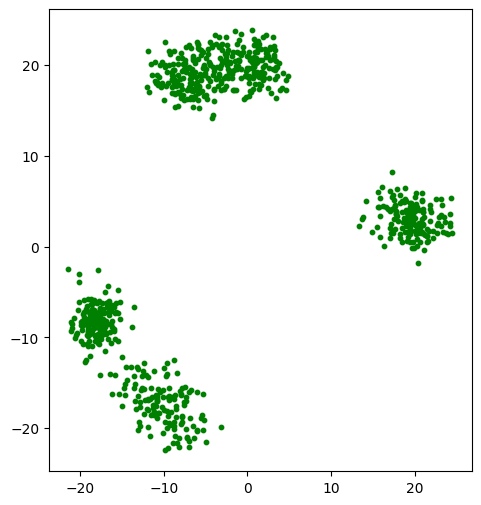

In [19]:
!wget -q https://github.com/princeton-cos324/pa2/raw/main/simulated_data.npy
Xt = np.load("simulated_data.npy")

# split into train / test
N = len(Xt) # number of samples
split = int(0.8*N) # keep 80% for train, 20% for val

Xt_train = Xt[0:split,:]
Xt_val= Xt[split:,:]
_ = plot_sample(Xt_train, [])

How many clusters does it look like the data can/should be split into? Why did you pick that number?  
(Optional, what could these clusters be if these points corresponded to our song data as described at the start?)

**4 clusters because there is 4 rather distinct groupings each with a different centroid. The bottom left dots are closer to each other than the others but it can also be split as there is substantial distance between dots in that area. These clusters could be different music genres based on the average pitch and amplitude where clusters to the top right represent louder and higher treble songs.**

### ACT 7: running k-means on simulated data (6 pts)
Run your k-means function on the training data `Xt_train`, report the loss vector and use `plot_sample` to plot the clusters.  
**Run each cell multiple times to see how the random initialization changes the final clusters.**  
**Name your vector of associated centroids** `assoc`**, this will be relevant later**

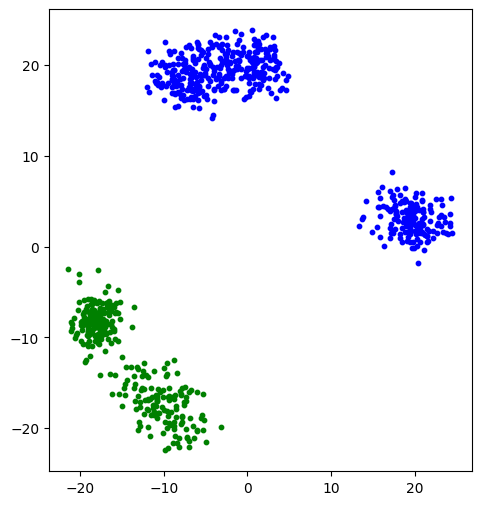

[386.9007976335776, 173.35925282271594, 138.08343816447206, 138.08343816447206]


In [20]:
# ACT7a: Run k-means clustering on Xt_train, using k = 2 clusters (2 pts)

W, loss_vector = k_means(Xt_train, 2)
loss, assoc = associate_centroids(Xt_train, W)
plot_sample(Xt_train, assoc)
print(loss_vector)

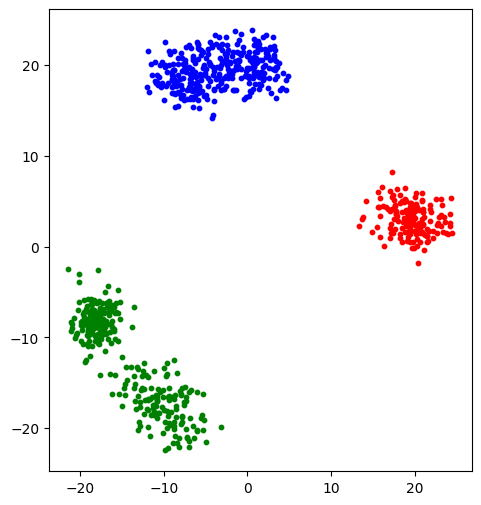

[128.9719261386885, 49.15525457280205, 27.29721065703112, 27.29721065703112]


In [21]:
# ACT7b: Run k-means clustering on Xt_train, using k = 3 clusters (2 pts)

W, loss_vector = k_means(Xt_train, 3)
loss, assoc = associate_centroids(Xt_train, W)
plot_sample(Xt_train, assoc)
print(loss_vector)

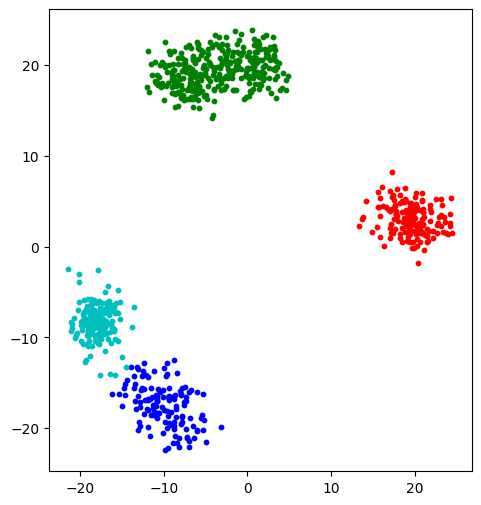

[36.93210686326223, 13.795943389027284, 13.795317150936507, 13.795317150936507]


In [23]:
# ACT7c: Run k-means clustering on Xt_train, using k = 4 clusters (2 pts)
# you might need to run this one several times to get the `expected` clusters

W, loss_vector = k_means(Xt_train, 4)
loss, assoc = associate_centroids(Xt_train, W)
plot_sample(Xt_train, assoc)
print(loss_vector)

### ACT 8: Loss Curves (19 pts)
Let's look at how our final loss changes as a function of `k`, the cluster count (i.e. let's see those elbow curves). For each `k` value in the range of `1,...,20` run k-means `20` times (to average out the variability from the initialization). Record the mean training and validation loss for each set of runs.

Finally, make a **well-labeled** plot of training and validation losses versus `k`.

**Hint:** you should never be running `k_means` on the validation dataset, *another function* you defined above can return you the validation loss given the centroid locations you learned from the training set

k = 1, Training Loss = 381.53711284483444, Validation Loss = 269.55316056155397
k = 2, Training Loss = 183.88496523405627, Validation Loss = 157.47121084260192
k = 3, Training Loss = 48.15182608743076, Validation Loss = 59.63186091633029
k = 4, Training Loss = 29.29680295448652, Validation Loss = 39.57380845193127
k = 5, Training Loss = 14.522810700445124, Validation Loss = 24.24333068901805
k = 6, Training Loss = 11.20446507212053, Validation Loss = 19.384600201049306
k = 7, Training Loss = 11.591538080005314, Validation Loss = 20.254691340668938
k = 8, Training Loss = 6.3112506787757905, Validation Loss = 12.501677381441896
k = 9, Training Loss = 8.278201595674618, Validation Loss = 14.828671195889374
k = 10, Training Loss = 6.438799883495686, Validation Loss = 12.453724207330819
k = 11, Training Loss = 6.208321379514847, Validation Loss = 11.882302905901948
k = 12, Training Loss = 5.297010032832818, Validation Loss = 10.757245946969402
k = 13, Training Loss = 4.093847842145411, Vali

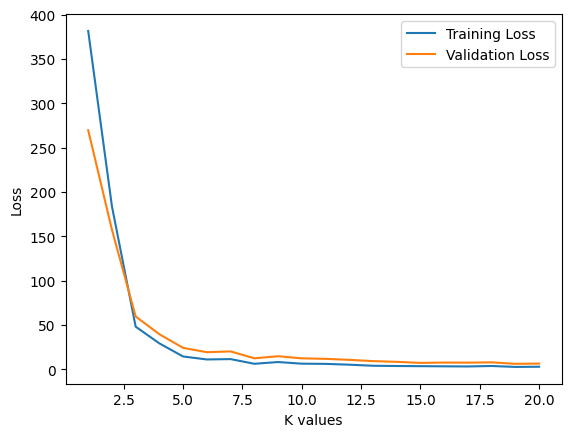

In [24]:
# Act8: build elbow curve of train + val losses (10 pts)
# Warning, this code should take 20-30 seconds to run; if it's taking forever, you probably didn't
# vectorize your k-means code correctly (remember, no for loops over the data points)

training_losses = []
validation_losses = []
k_values = range(1, 21)

for k in k_values: # iterate from k = 1 to k = 20
  training_loss_k = []
  validation_loss_k = []

  for i in range(20): # run each k 20 times
    W, loss = k_means(Xt_train, k)
    training_loss_k.append(loss[-1]) # append the final loss value
    validation_loss_k.append(associate_centroids(Xt_val, W)[0])

  mean_training_loss = np.mean(training_loss_k) # record mean training loss
  mean_validation_loss = np.mean(validation_loss_k) # record mean validation loss

  training_losses.append(mean_training_loss)
  validation_losses.append(mean_validation_loss)
  print(f"k = {k}, Training Loss = {mean_training_loss}, Validation Loss = {mean_validation_loss}")


plt.plot(k_values, training_losses, label = "Training Loss")
plt.plot(k_values, validation_losses, label = "Validation Loss")
plt.xlabel("K values")
plt.ylabel("Loss")
plt.legend()
plt.show()

Around how many clusters do we see the *elbow* in the loss curve (look back to the lecture slides if you need a reminder on what the elbow is).  
Does this make sense given your previous observations on the distribution of the data? (2 pts)

**The elbow is between 2.5 and 5 clusters which would be 3 or 4 which makes sense as the distribution of data seems to suggest 3 or 4 clusters.**

It looks like we can minimize both the validation and training loss by taking more and more clusters.
Why would this be a bad idea in practice? Does having a ton of clusters likely reduce or increase
our ability to infer useful information from the data? (2 pts)

**This would be a bad idea because we want distinct and "good" quality clusters. Having a ton of clusters will reduce our ability to infer useful information because all the data points will be forced to split into smaller groups even if in already appropiate groupings. Reducing training loss does not necessarily mean useful information for users.**

#### Experimenting With MNIST Data

Now that we understand some of the behavior of K-means for our simulated dataset, let's see how this extends to images of digits.

In [25]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

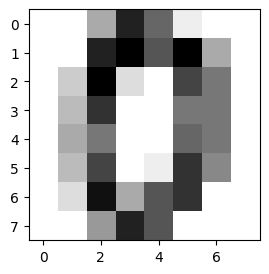

In [26]:
#Load the digits dataset
digits = load_digits()

#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [27]:
# load digits zero and one
X_digits, y_digits = load_digits(n_class=2, return_X_y=True)
Xt = scale(X_digits)
N = len(Xt)
split = int(0.8*N) # keep 80% for train, 20% for val

Xt_train = Xt[0:split,:]
Xt_val= Xt[split:,:]

In [28]:
# use PCA to reduce the data dimension to 2 for plotting
reduced_data = PCA(n_components=2).fit_transform(Xt_train)

Let's visualize this PCA-reduced data:

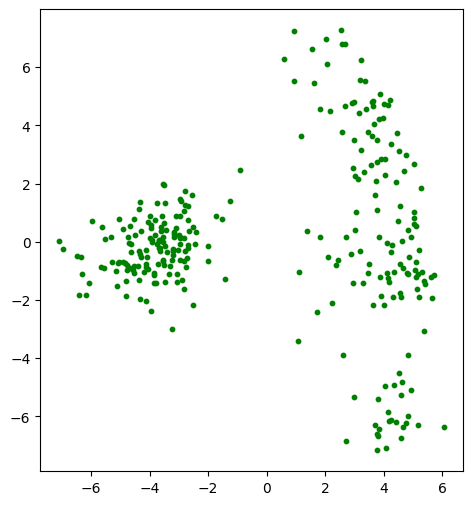

In [29]:
_ = plot_sample(reduced_data, [])

Does this data look *clusterable*? How many clusters do we expect? Why does this make sense given the data we loaded above? (5 pts)

**Yes it looks clusterable. We expect 2 clusters because 1 cluster represents the 0 digit and the other for the 1 digit.**

### ACT 9: K-means on MNIST data (5 pts)
Run your k-means clustering code on this data and plot the clusters.

In [30]:
# ACT9: Run k-means on MNIST data with k=2

# YOUR CODE HERE
W, loss = k_means(Xt_train, 2)
loss, assoc = associate_centroids(Xt_train, W)

Lets plot some representative samples from this clustering:

In [31]:
cluster_0 = Xt_train[np.where(assoc==0)]
cluster_1 = Xt_train[np.where(assoc==1)]

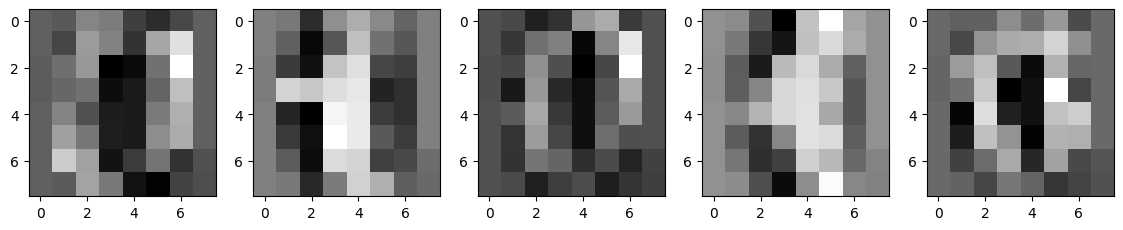

In [32]:
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(14,14)
for i, ax in enumerate(axs):
    ax.imshow(cluster_0[i].reshape(8,8), cmap="gray")

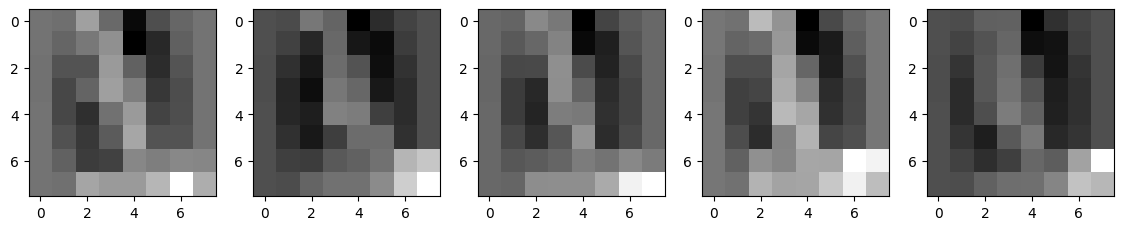

In [33]:
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(14,14)
for i, ax in enumerate(axs):
    ax.imshow(cluster_1[i].reshape(8,8), cmap="gray")

Do the images in each cluster look similar? If the code is working correctly they hopefully should!  
Note that the zero-th cluster might not correspond to the digit zero. If you were to use this system for digit classification, you'd manually have to look at some representatives of each cluster before, label them yourself, and then apply those labels to the rest of the data based on which cluster they belong to (this is still a lot more efficient than manually labeling a thousand numbers though).

### ACT 10: More Elbow Curves (6 pts)
Copy your code from ACT 8, and plot train and validation loss curves for this MNIST data.

k = 1, Training Loss = 53.274774636536414, Validation Loss = 47.16207633825984
k = 2, Training Loss = 39.01038773353347, Validation Loss = 36.700023027312795
k = 3, Training Loss = 35.075910230379606, Validation Loss = 33.97835863492632
k = 4, Training Loss = 30.77960114783992, Validation Loss = 30.62498033244001
k = 5, Training Loss = 28.3767578274471, Validation Loss = 29.092859686085053
k = 6, Training Loss = 26.489840735099285, Validation Loss = 27.840536542818732
k = 7, Training Loss = 25.312489742342272, Validation Loss = 26.79969857320801
k = 8, Training Loss = 24.104979831491676, Validation Loss = 26.201273079775483
k = 9, Training Loss = 22.510245621068982, Validation Loss = 25.086410032308347
k = 10, Training Loss = 21.61809503395163, Validation Loss = 24.278311390236446
k = 11, Training Loss = 20.586315480942446, Validation Loss = 24.334650138413274
k = 12, Training Loss = 19.96661360964333, Validation Loss = 23.722163275595356
k = 13, Training Loss = 19.275697853910785, Val

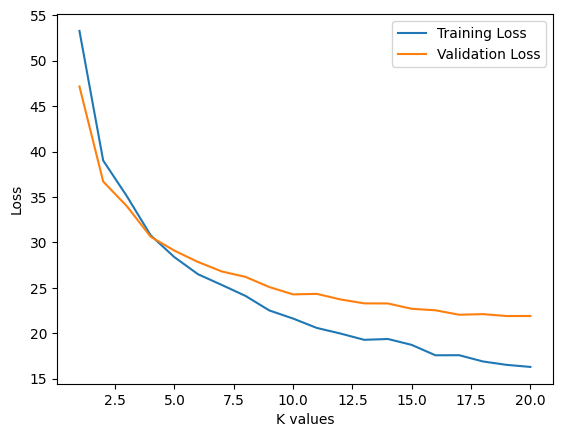

In [34]:
# Act10: build elbow curve of train + val losses (5 pts)
# Warning, this code should take <= 20-30 seconds to run; if it's taking forever, you probably didn't
# vectorize your k-means code correctly (remember, no for loops over the data points)

# YOUR CODE HERE
training_losses = []
validation_losses = []
k_values = range(1, 21)

for k in k_values: # iterate from k = 1 to k = 20
  training_loss_k = []
  validation_loss_k = []

  for i in range(20): # run each k 20 times
    W, loss = k_means(Xt_train, k)
    training_loss_k.append(loss[-1]) # append the final loss value
    validation_loss_k.append(associate_centroids(Xt_val, W)[0])

  mean_training_loss = np.mean(training_loss_k) # record mean training loss
  mean_validation_loss = np.mean(validation_loss_k) # record mean validation loss

  training_losses.append(mean_training_loss)
  validation_losses.append(mean_validation_loss)
  print(f"k = {k}, Training Loss = {mean_training_loss}, Validation Loss = {mean_validation_loss}")


plt.plot(k_values, training_losses, label = "Training Loss")
plt.plot(k_values, validation_losses, label = "Validation Loss")
plt.xlabel("K values")
plt.ylabel("Loss")
plt.legend()
plt.show()

Do the loss curves above go down as the number of clusters increase? Despite this, why would it make no sense to pick an extremely large value of K for an application like digit classification? (1 pt)

**The curve goes down as the number of clusters increase. It would not make any sense to pick an extremely large value of K because K should not be more than the number of digits we are looking to classify. This could lead to multiple clusters for a single digit which does not make sense.**

###ACT 11 (Extra Credit): Compare K-means and K-means++

In this question, you will compare K-Means and K-Means++ algorithms.

We provide the function to initialize centroids for K-means++. Make sure you read through the code and understand how to call this function.

In [35]:
def plus_init(X,k):
    '''
    Inputs:
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    k is the number of clusters
    Outputs:
    C a 2-D Numpy array of shape (k, d) of points at which to initialise centroids for k-means++
    '''
    n, d = X.shape[0], X.shape[1]
    C = np.zeros((k, d), dtype=float)
    remain_index = list(range(n))

    # random init
    zero_init = np.random.randint(n)
    C[0] = X[zero_init]
    remain_index.remove(zero_init)
    for idx in range(1, k):
        dx2 = compute_sq_dists(X[remain_index], C[:idx])
        dx2 = np.min(dx2, axis=-1)
        prob_dx = dx2 / np.sum(dx2)
        new_idx = np.random.choice(remain_index, p=prob_dx)
        C[idx] = X[new_idx]
        remain_index.remove(new_idx)
    return C

In the function `k_means_plus()`, implement the main iteration loop for K-Means++, alternating between associating data points to their nearest center, and estimating new centers.

**Hint**: This should be similar to your `k_means()` function in ACT6.

In [ ]:
# ACT 11 implement the K-means++ loop
# similar to ACT6
def k_means_plus(X, k, max_iters=50, eps=1e-5):
    '''
    Perform k-means++ clusting on X using k clusters, running for max_iters loops,
    and stop early if loss decreases by a proportion less than eps.
    Early stopping does not occur before epoch 2.

    Output (W, loss): the final centers W and loss is a list containing loss values at each iteration
    '''

    # YOUR CODE HERE

    return W, loss

Now, run your k-means++ clustering code on MNIST data and plot the clusters.

**Hint**: This should be similar to your code implementation in ACT9.

In [ ]:
# ACT12: Run k-means++ on MNIST data with k=2

# YOUR CODE HERE

Compare following behaviors of the random initialization versus the K-means++ initialization:

*   spread of initial cluster centers
*   final sum of cluster costs
*   number of timesteps it take to converge

**Answer:**

*  
*
*


